# TS-Forecast Tutorial

Learn how to:
- Forecast **multivariate time series** (multiple variables at once)
- Use AutoForecaster to compare models automatically
- Add covariates (external features) to improve forecasts
- Handle categorical and numerical features (automatic preprocessing)

## Part 1: Basic Usage

In [1]:
import sys
from pathlib import Path

# Add src to path so we can import ts_forecast
src_path = Path.cwd().parent / 'src'
if str(src_path) not in sys.path:
    sys.path.insert(0, str(src_path))

print(f"Added to path: {src_path}")

Added to path: c:\forecasting\ts-forecast-mvp\src


In [2]:
from ts_forecast import (
    MovingAverageForecaster,
    VARForecaster, 
    RandomForestForecaster,
    XGBoostForecaster,
    AutoForecaster
)
print("Imports successful!")

Imports successful!


### Generate Multivariate Data

Create a time series with **3 variables** (e.g., sales across different regions):

### Generate Sample Data

Multivariate time series shape: (200, 3)
                 North       South        East
2023-01-01  102.483571  122.146724   83.622289
2023-01-02  115.447821  136.477026  105.255054
2023-01-03  123.742026  143.303184  112.373911
2023-01-04  117.800362  135.073997  101.090149
2023-01-05   92.161609  107.203904   80.463341


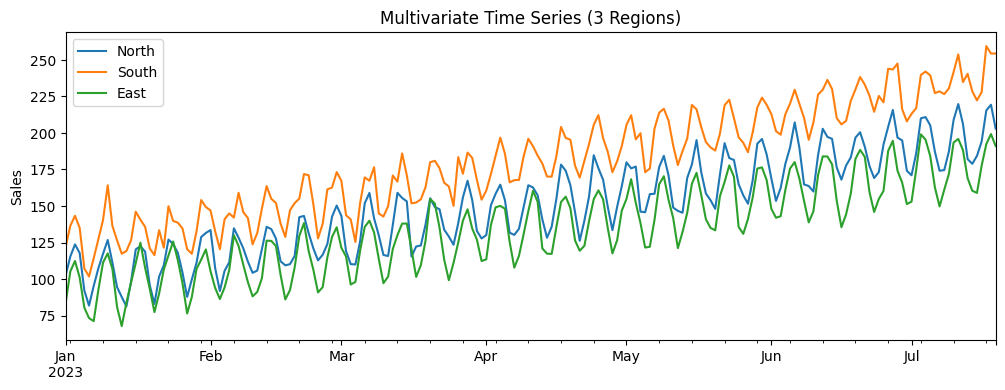

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Generate MULTIVARIATE time series (3 variables)
np.random.seed(42)
dates = pd.date_range('2023-01-01', periods=200, freq='D')
trend = np.linspace(100, 200, 200)
seasonality = 20 * np.sin(2 * np.pi * np.arange(200) / 7)

# Create 3 correlated time series
region_north = trend + seasonality + np.random.normal(0, 5, 200)
region_south = trend * 1.2 + seasonality * 0.8 + np.random.normal(0, 6, 200)
region_east = trend * 0.9 + seasonality * 1.1 + np.random.normal(0, 4, 200)

df = pd.DataFrame({
    'North': region_north,
    'South': region_south,
    'East': region_east
}, index=dates)

print(f"Multivariate time series shape: {df.shape}")
print(df.head())

# Plot all three series
df.plot(figsize=(12, 4), title='Multivariate Time Series (3 Regions)')
plt.ylabel('Sales')
plt.show()

### Train/Test Split

In [4]:
y_train = df.iloc[:150]
y_test = df.iloc[150:]

print(f"Train: {len(y_train)} samples")
print(f"Test: {len(y_test)} samples")

Train: 150 samples
Test: 50 samples


### Try a Single Model

In [5]:
# Train a simple model on the multivariate data
model = MovingAverageForecaster(horizon=30, window=7)  # Set forecast horizon during initialization
model.fit(y_train)

# Make predictions (horizon already set)
predictions = model.predict()
print(predictions)

         North       South        East
0   173.001019  204.154454  155.066846
1   173.001019  204.154454  155.066846
2   173.001019  204.154454  155.066846
3   173.001019  204.154454  155.066846
4   173.001019  204.154454  155.066846
5   173.001019  204.154454  155.066846
6   173.001019  204.154454  155.066846
7   173.001019  204.154454  155.066846
8   173.001019  204.154454  155.066846
9   173.001019  204.154454  155.066846
10  173.001019  204.154454  155.066846
11  173.001019  204.154454  155.066846
12  173.001019  204.154454  155.066846
13  173.001019  204.154454  155.066846
14  173.001019  204.154454  155.066846
15  173.001019  204.154454  155.066846
16  173.001019  204.154454  155.066846
17  173.001019  204.154454  155.066846
18  173.001019  204.154454  155.066846
19  173.001019  204.154454  155.066846
20  173.001019  204.154454  155.066846
21  173.001019  204.154454  155.066846
22  173.001019  204.154454  155.066846
23  173.001019  204.154454  155.066846
24  173.001019  204.15445

### Use AutoForecaster (Compare Multiple Models)

In [6]:
# Define candidate models (all work with multivariate data)
candidate_models = [
    MovingAverageForecaster(horizon=30, window=7),
    VARForecaster(horizon=30, lags=7),
    RandomForestForecaster(horizon=30, n_estimators=100),
    XGBoostForecaster(horizon=30, n_estimators=100)
]

# Train and compare models automatically (reduced splits for smaller dataset)
auto = AutoForecaster(candidate_models=candidate_models, metric='rmse', n_splits=3, test_size=10)
auto.fit(y_train)

AUTO FORECASTER: Model Selection with Backtesting

📊 Data: 150 observations, 3 variables
🔍 Evaluating 4 candidate models
📈 Backtesting: 3 splits, 10 test size
🎯 Selection metric: RMSE
🔄 Window type: expanding

[1/4] Testing MovingAverageForecaster(window=7)...
   RMSE: 15.9421
[2/4] Testing VARForecaster(lags=7)...


c:\Users\weibi\AppData\Local\Python\pythoncore-3.14-64\Lib\site-packages\numpy\_core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


   RMSE: 16.6114
[3/4] Testing RandomForestForecaster...
   ⚠️ Error: Found input variables with inconsistent numbers of samples: [112, 119]
[4/4] Testing XGBoostForecaster...
   ⚠️ Error: [23:19:18] C:\actions-runner\_work\xgboost\xgboost\src\data\data.cc:557: Check failed: this->labels.Size() % this->num_row_ == 0 (7 vs. 0) : Incorrect size for labels: (119,1) v.s. 112

🏆 BEST MODEL SELECTED: MovingAverageForecaster(window=7)
   Performance: RMSE = 15.9421

🔄 Retraining best model on full dataset...
✅ Training complete!


c:\Users\weibi\AppData\Local\Python\pythoncore-3.14-64\Lib\site-packages\numpy\_core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\weibi\AppData\Local\Python\pythoncore-3.14-64\Lib\site-packages\numpy\_core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\weibi\AppData\Local\Python\pythoncore-3.14-64\Lib\site-packages\numpy\_core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the 

### Make Forecasts

In [7]:
# Get forecasts for all 3 variables from the best model
forecasts = auto.forecast()
print(f"Forecast shape: {forecasts.shape}")  # (30, 3) - 30 steps for 3 variables
print(forecasts.head())


🔮 Generating forecasts...
✅ Generated 30 step forecast
   Variables: North, South, East
Forecast shape: (30, 3)
        North       South        East
0  173.001019  204.154454  155.066846
1  173.001019  204.154454  155.066846
2  173.001019  204.154454  155.066846
3  173.001019  204.154454  155.066846
4  173.001019  204.154454  155.066846


## Part 2: Multivariate with Covariates

Now let's add **external features (covariates)** to improve forecasts for multivariate targets.

**The package automatically handles:**
- Categorical features (e.g., "Monday", "Sunny") → one-hot encoded
- Numerical features (e.g., temperature=20.5) → used directly

### Generate Data with Covariates

In [8]:
# Generate MULTIVARIATE targets with covariates
np.random.seed(42)
dates = pd.date_range('2023-01-01', periods=200, freq='D')

# COVARIATES (features) - same for all targets
day_names = dates.day_name()  # CATEGORICAL
temperature = 20 + 10 * np.sin(2 * np.pi * np.arange(200) / 365) + np.random.normal(0, 2, 200)  # NUMERICAL
is_weekend = (dates.dayofweek >= 5).astype(float)  # NUMERICAL

X = pd.DataFrame({
    'day_name': day_names,
    'temperature': temperature,
    'is_weekend': is_weekend
}, index=dates)

# MULTIVARIATE TARGETS (3 regions influenced by covariates)
sales_north = 100 + 0.5 * temperature + 30 * is_weekend + np.random.normal(0, 5, 200)
sales_south = 120 + 0.6 * temperature + 25 * is_weekend + np.random.normal(0, 6, 200)
sales_east = 90 + 0.4 * temperature + 35 * is_weekend + np.random.normal(0, 4, 200)

y = pd.DataFrame({
    'North': sales_north,
    'South': sales_south,
    'East': sales_east
}, index=dates)

print("Target (y) - MULTIVARIATE:")
print(f"  Shape: {y.shape}")
print(y.head())
print("\nCovariates (X):")
print(f"  Shape: {X.shape}")
print(X.head())

Target (y) - MULTIVARIATE:
  Shape: (200, 3)
                 North       South        East
2023-01-01  142.285651  148.029491  136.425326
2023-01-02  112.751725  128.341113   94.269581
2023-01-03  116.235053  133.015218  102.134261
2023-01-04  117.050138  134.419237  104.847454
2023-01-05  103.221512  129.431438   99.741627

Covariates (X):
  Shape: (200, 3)
             day_name  temperature  is_weekend
2023-01-01     Sunday    20.993428         1.0
2023-01-02     Monday    19.895605         0.0
2023-01-03    Tuesday    21.639593         0.0
2023-01-04  Wednesday    23.562256         0.0
2023-01-05   Thursday    20.219718         0.0


### Split Data

In [9]:
y_train, y_test = y.iloc[:150], y.iloc[150:]
X_train, X_test = X.iloc[:150], X.iloc[150:]

print(f"Training: {len(y_train)} samples")
print(f"Test: {len(y_test)} samples")

Training: 150 samples
Test: 50 samples


### Train with Covariates

In [ ]:
# Train without covariates
model_no_cov = RandomForestForecaster(horizon=50)
model_no_cov.fit(y_train)
pred_no_cov = model_no_cov.predict()

# Train with covariates (automatically preprocesses categorical & numerical features)
model_with_cov = RandomForestForecaster(horizon=50)
model_with_cov.fit(y_train, X_train)
pred_with_cov = model_with_cov.predict(X_test)

# Compare RMSE for each variable
from sklearn.metrics import root_mean_squared_error
for col in y_test.columns:
    rmse_no = root_mean_squared_error(y_test[col], pred_no_cov[col])
    rmse_with = root_mean_squared_error(y_test[col], pred_with_cov[col])
    print(f"{col}: RMSE without covariates = {rmse_no:.2f}, with covariates = {rmse_with:.2f}")

c:\forecasting\ts-forecast-mvp\src\ts_forecast\models\external.py:286: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  model.fit(X_train[valid_idx], y_shifted[target_col][valid_idx])


XGBoostError: [23:19:18] C:\actions-runner\_work\xgboost\xgboost\src\data\data.cc:557: Check failed: this->labels.Size() % this->num_row_ == 0 (7 vs. 0) : Incorrect size for labels: (149,1) v.s. 142

### Visualize Results

In [ ]:
# Plot results for all 3 regions
fig, axes = plt.subplots(3, 1, figsize=(12, 8))
for i, col in enumerate(y.columns):
    ax = axes[i]
    ax.plot(y_train.index, y_train[col], label='Train', alpha=0.5)
    ax.plot(y_test.index, y_test[col], label='Actual', color='green', linewidth=2)
    ax.plot(y_test.index, pred_with_cov[col], label='With Covariates', 
            color='red', linestyle='--', linewidth=2)
    ax.plot(y_test.index, pred_no_cov[col], label='Without Covariates', 
            color='orange', linestyle=':', linewidth=2)
    ax.set_ylabel(col)
    ax.legend()
    ax.grid(True, alpha=0.3)
plt.suptitle('Multivariate Forecasting with Covariates')
plt.tight_layout()
plt.show()

### AutoForecaster with Covariates

In [ ]:
# Use AutoForecaster with covariates (multivariate targets)
candidate_models = [
    RandomForestForecaster(horizon=50)
]
auto = AutoForecaster(candidate_models=candidate_models, metric='rmse', n_splits=3, test_size=10)
auto.fit(y_train, X_train)
forecasts = auto.forecast(X_test)
print(f"Best model: {auto.best_model_name_}")
print(forecasts.head())

**Summary:**
- **Horizon** is set during model initialization: `model = XGBoostForecaster(horizon=30)`
- **Multivariate:** All models handle multiple target variables (columns in `y`)
- **Covariates:** Categorical and numerical features are automatically preprocessed
- **AutoForecaster:** Compares models and selects the best one

**Template for your own multivariate data:**
```python
from ts_forecast import AutoForecaster, XGBoostForecaster, RandomForestForecaster

# Your multivariate data: y = DataFrame with multiple columns, X = optional covariates
model = XGBoostForecaster(horizon=30)
model.fit(y_train, X_train)  # X can have categorical & numerical columns
predictions = model.predict(X_test)  # Returns forecasts for all target variables
```